In [1]:
import gym

import numpy as np

import torch
import torch.nn as nn
import torch.optim as opt

import torch.nn.functional as F

import random

from collections import namedtuple
import collections

import math

In [2]:
step = namedtuple("step", ("state", "action", "next_state", "reward"))

class Memory():
    def __init__(self, size):
        self.saved = collections.deque(maxlen = size)
    
    def sample(self, size):
        if len(self.saved) < size:
            return None
        else:
            return random.sample(self.saved, size)
            
    def push(self, data):
        self.saved.append(data)
        
    def __len__(self):
        return len(self.saved)

In [3]:
class QNet(nn.Module):
    def __init__(self, in_size, hidden_size, out_size):
        super(QNet, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(in_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, out_size)
        )
        
    def forward(self, x):
        return self.net(x)

In [4]:
env = gym.make("Acrobot-v1")

IN_SIZE = env.observation_space.shape[0]
OUT_SIZE = env.action_space.n
HIDDEN = 64

LR = 0.0005
GAMMA = 0.95

EPS = 0.9
EPS_ = 0.01
EPS_DECAY = 2000

HIST_SIZE = 30000
BATCH = 256

EPOCH = 2000
TARGET_LOAD = 10
FRAME_SAVE = 20

POS_REW = 100

hist = Memory(HIST_SIZE)
policy_net = QNet(IN_SIZE, HIDDEN, OUT_SIZE)
target_net = QNet(IN_SIZE, HIDDEN, OUT_SIZE)
target_net.eval()
target_net.load_state_dict(policy_net.state_dict())

optim = opt.Adam(policy_net.parameters(), lr=LR)
criterion = nn.MSELoss()

step_count = 0

In [5]:
env.render()

In [6]:
snapshot = []

for epoch in range(EPOCH):
    obs = env.reset()
    count = 0
    rew = 0.
    
    loss_sum = 0
    
    frame = []
    
    if epoch%FRAME_SAVE == FRAME_SAVE - 1:
        frame.append(env.render(mode='rgb_array'))
    while True:
        eps = EPS_ + (EPS-EPS_) * math.exp(-1*epoch/EPS_DECAY)
        
        if random.random() < eps:
            act = env.action_space.sample()
        else:
            with torch.no_grad():
                act = policy_net(torch.FloatTensor(obs)).argmax().item()
        
        next_obs, rew, done, _ = env.step(act)
        if epoch%FRAME_SAVE == FRAME_SAVE - 1:
            frame.append(env.render(mode='rgb_array'))
        step_count += 1
        count += 1
        
        if done and rew == 0:
            rew = POS_REW
        hist.push(step(obs, act, next_obs, rew))
        
        sample = hist.sample(BATCH)
        if sample:
            sample = step(*zip(*sample))
            
            states = torch.FloatTensor(sample.state)
            actions = torch.LongTensor(sample.action)
            next_states = torch.FloatTensor(sample.next_state)
            rewards  =torch.FloatTensor(sample.reward)
            
            Qpred = policy_net(states).gather(1, actions.unsqueeze(1))
            Q = rewards.unsqueeze(1) + GAMMA * target_net(next_states).detach().max(1)[0].unsqueeze(1)
            
            optim.zero_grad()
            loss = criterion(Qpred, Q)
            loss.backward()
            optim.step()
            
            loss_sum+= loss.item()
            
        if done:
            break
        obs = next_obs
        
    if epoch%TARGET_LOAD == 0:
        target_net.load_state_dict(policy_net.state_dict())
    if epoch%FRAME_SAVE == FRAME_SAVE - 1:
        if count < 150:
            snapshot.append((epoch, count, frame))
        
    print("Epoch : %d, count : %d loss : %.6f"%(epoch, count, loss_sum/count))

Epoch : 0, count : 500 loss : 0.061384
Epoch : 1, count : 500 loss : 0.030225
Epoch : 2, count : 500 loss : 0.000887
Epoch : 3, count : 500 loss : 0.000631
Epoch : 4, count : 500 loss : 0.001092
Epoch : 5, count : 500 loss : 0.001028
Epoch : 6, count : 500 loss : 0.000650
Epoch : 7, count : 500 loss : 0.000494
Epoch : 8, count : 500 loss : 0.000414
Epoch : 9, count : 500 loss : 0.000352
Epoch : 10, count : 500 loss : 0.000320
Epoch : 11, count : 500 loss : 0.012899
Epoch : 12, count : 500 loss : 0.000990
Epoch : 13, count : 500 loss : 0.000740
Epoch : 14, count : 500 loss : 0.000609
Epoch : 15, count : 500 loss : 0.000519
Epoch : 16, count : 500 loss : 0.000494
Epoch : 17, count : 500 loss : 0.000479
Epoch : 18, count : 500 loss : 0.000451
Epoch : 19, count : 500 loss : 0.000433
Epoch : 20, count : 500 loss : 0.000407
Epoch : 21, count : 500 loss : 0.010746
Epoch : 22, count : 500 loss : 0.000988
Epoch : 23, count : 494 loss : 0.000942
Epoch : 24, count : 500 loss : 0.700950
Epoch : 25

Epoch : 202, count : 500 loss : 3.666517
Epoch : 203, count : 374 loss : 4.068693
Epoch : 204, count : 350 loss : 2.960640
Epoch : 205, count : 500 loss : 4.917278
Epoch : 206, count : 334 loss : 3.690108
Epoch : 207, count : 488 loss : 3.486284
Epoch : 208, count : 500 loss : 4.606573
Epoch : 209, count : 500 loss : 4.082080
Epoch : 210, count : 500 loss : 3.304232
Epoch : 211, count : 408 loss : 4.765627
Epoch : 212, count : 500 loss : 4.618196
Epoch : 213, count : 500 loss : 4.439522
Epoch : 214, count : 500 loss : 4.272604
Epoch : 215, count : 500 loss : 4.579772
Epoch : 216, count : 500 loss : 4.659960
Epoch : 217, count : 471 loss : 4.271943
Epoch : 218, count : 500 loss : 4.229798
Epoch : 219, count : 500 loss : 4.336453
Epoch : 220, count : 500 loss : 4.161452
Epoch : 221, count : 500 loss : 4.536828
Epoch : 222, count : 347 loss : 5.103314
Epoch : 223, count : 500 loss : 3.994656
Epoch : 224, count : 303 loss : 4.599070
Epoch : 225, count : 500 loss : 4.644075
Epoch : 226, cou

Epoch : 398, count : 331 loss : 26.281204
Epoch : 399, count : 500 loss : 25.672228
Epoch : 400, count : 437 loss : 27.480454
Epoch : 401, count : 352 loss : 27.437896
Epoch : 402, count : 353 loss : 27.051200
Epoch : 403, count : 500 loss : 24.245703
Epoch : 404, count : 484 loss : 25.702247
Epoch : 405, count : 419 loss : 25.577134
Epoch : 406, count : 500 loss : 27.342109
Epoch : 407, count : 396 loss : 24.829587
Epoch : 408, count : 383 loss : 25.310731
Epoch : 409, count : 500 loss : 24.967251
Epoch : 410, count : 500 loss : 24.318242
Epoch : 411, count : 394 loss : 25.806296
Epoch : 412, count : 330 loss : 22.836524
Epoch : 413, count : 198 loss : 27.724452
Epoch : 414, count : 444 loss : 25.226667
Epoch : 415, count : 500 loss : 25.874121
Epoch : 416, count : 500 loss : 24.301753
Epoch : 417, count : 365 loss : 26.789326
Epoch : 418, count : 500 loss : 24.249538
Epoch : 419, count : 500 loss : 22.707201
Epoch : 420, count : 500 loss : 22.770110
Epoch : 421, count : 500 loss : 25

Epoch : 593, count : 323 loss : 38.391298
Epoch : 594, count : 340 loss : 38.668332
Epoch : 595, count : 261 loss : 37.887161
Epoch : 596, count : 382 loss : 37.769988
Epoch : 597, count : 279 loss : 35.807026
Epoch : 598, count : 161 loss : 37.025173
Epoch : 599, count : 269 loss : 36.168630
Epoch : 600, count : 476 loss : 37.938906
Epoch : 601, count : 203 loss : 39.030275
Epoch : 602, count : 433 loss : 37.171785
Epoch : 603, count : 268 loss : 37.706416
Epoch : 604, count : 455 loss : 37.376121
Epoch : 605, count : 227 loss : 41.525706
Epoch : 606, count : 310 loss : 38.154873
Epoch : 607, count : 316 loss : 35.015819
Epoch : 608, count : 169 loss : 37.540149
Epoch : 609, count : 216 loss : 33.920967
Epoch : 610, count : 330 loss : 35.954342
Epoch : 611, count : 425 loss : 36.518453
Epoch : 612, count : 273 loss : 36.230076
Epoch : 613, count : 239 loss : 35.784753
Epoch : 614, count : 289 loss : 37.223144
Epoch : 615, count : 379 loss : 37.650841
Epoch : 616, count : 240 loss : 35

Epoch : 788, count : 191 loss : 59.623908
Epoch : 789, count : 250 loss : 57.618795
Epoch : 790, count : 326 loss : 56.100394
Epoch : 791, count : 357 loss : 54.534793
Epoch : 792, count : 500 loss : 55.349672
Epoch : 793, count : 309 loss : 52.352978
Epoch : 794, count : 269 loss : 55.562269
Epoch : 795, count : 262 loss : 55.703241
Epoch : 796, count : 215 loss : 54.525101
Epoch : 797, count : 194 loss : 54.947560
Epoch : 798, count : 174 loss : 54.151069
Epoch : 799, count : 210 loss : 55.231659
Epoch : 800, count : 285 loss : 57.038934
Epoch : 801, count : 262 loss : 56.840436
Epoch : 802, count : 240 loss : 57.974114
Epoch : 803, count : 213 loss : 57.601634
Epoch : 804, count : 269 loss : 54.552846
Epoch : 805, count : 240 loss : 54.986325
Epoch : 806, count : 364 loss : 56.035952
Epoch : 807, count : 500 loss : 56.987979
Epoch : 808, count : 227 loss : 57.114661
Epoch : 809, count : 206 loss : 57.150383
Epoch : 810, count : 268 loss : 58.170654
Epoch : 811, count : 201 loss : 59

Epoch : 983, count : 292 loss : 67.492920
Epoch : 984, count : 154 loss : 71.782824
Epoch : 985, count : 210 loss : 69.355009
Epoch : 986, count : 243 loss : 69.184661
Epoch : 987, count : 253 loss : 65.579582
Epoch : 988, count : 218 loss : 69.473137
Epoch : 989, count : 159 loss : 69.964928
Epoch : 990, count : 160 loss : 67.876915
Epoch : 991, count : 338 loss : 71.735147
Epoch : 992, count : 205 loss : 69.417714
Epoch : 993, count : 180 loss : 68.442430
Epoch : 994, count : 196 loss : 72.352674
Epoch : 995, count : 213 loss : 70.261078
Epoch : 996, count : 152 loss : 74.002545
Epoch : 997, count : 258 loss : 68.374749
Epoch : 998, count : 202 loss : 68.227194
Epoch : 999, count : 151 loss : 71.306657
Epoch : 1000, count : 477 loss : 70.252254
Epoch : 1001, count : 208 loss : 71.758445
Epoch : 1002, count : 185 loss : 72.739144
Epoch : 1003, count : 215 loss : 70.739167
Epoch : 1004, count : 262 loss : 69.575917
Epoch : 1005, count : 135 loss : 69.531441
Epoch : 1006, count : 195 lo

Epoch : 1173, count : 145 loss : 77.597960
Epoch : 1174, count : 191 loss : 77.204735
Epoch : 1175, count : 264 loss : 76.592216
Epoch : 1176, count : 293 loss : 79.185973
Epoch : 1177, count : 190 loss : 82.247269
Epoch : 1178, count : 202 loss : 78.311650
Epoch : 1179, count : 152 loss : 79.081814
Epoch : 1180, count : 144 loss : 80.131105
Epoch : 1181, count : 178 loss : 81.433567
Epoch : 1182, count : 200 loss : 76.947885
Epoch : 1183, count : 205 loss : 79.085892
Epoch : 1184, count : 215 loss : 81.082169
Epoch : 1185, count : 172 loss : 83.172840
Epoch : 1186, count : 186 loss : 76.231902
Epoch : 1187, count : 152 loss : 83.743560
Epoch : 1188, count : 184 loss : 76.687668
Epoch : 1189, count : 204 loss : 80.076821
Epoch : 1190, count : 143 loss : 75.999957
Epoch : 1191, count : 192 loss : 78.631476
Epoch : 1192, count : 185 loss : 81.761672
Epoch : 1193, count : 222 loss : 76.890105
Epoch : 1194, count : 202 loss : 78.495763
Epoch : 1195, count : 192 loss : 78.020442
Epoch : 119

Epoch : 1363, count : 321 loss : 83.939833
Epoch : 1364, count : 159 loss : 82.588696
Epoch : 1365, count : 151 loss : 86.035156
Epoch : 1366, count : 170 loss : 84.087490
Epoch : 1367, count : 145 loss : 84.923745
Epoch : 1368, count : 170 loss : 84.535995
Epoch : 1369, count : 186 loss : 81.667445
Epoch : 1370, count : 165 loss : 82.021916
Epoch : 1371, count : 179 loss : 85.951493
Epoch : 1372, count : 186 loss : 86.095794
Epoch : 1373, count : 155 loss : 84.480825
Epoch : 1374, count : 151 loss : 85.252676
Epoch : 1375, count : 201 loss : 86.606738
Epoch : 1376, count : 163 loss : 85.732010
Epoch : 1377, count : 130 loss : 85.202406
Epoch : 1378, count : 240 loss : 90.094558
Epoch : 1379, count : 154 loss : 85.264868
Epoch : 1380, count : 146 loss : 86.782308
Epoch : 1381, count : 129 loss : 84.657677
Epoch : 1382, count : 109 loss : 85.952232
Epoch : 1383, count : 132 loss : 88.047016
Epoch : 1384, count : 180 loss : 85.662052
Epoch : 1385, count : 141 loss : 88.477251
Epoch : 138

Epoch : 1551, count : 169 loss : 103.758499
Epoch : 1552, count : 146 loss : 105.995007
Epoch : 1553, count : 160 loss : 105.234745
Epoch : 1554, count : 124 loss : 100.708481
Epoch : 1555, count : 146 loss : 104.579998
Epoch : 1556, count : 138 loss : 99.639054
Epoch : 1557, count : 264 loss : 109.613109
Epoch : 1558, count : 161 loss : 106.876485
Epoch : 1559, count : 234 loss : 107.992237
Epoch : 1560, count : 132 loss : 99.570557
Epoch : 1561, count : 159 loss : 108.536937
Epoch : 1562, count : 136 loss : 107.505235
Epoch : 1563, count : 168 loss : 102.958268
Epoch : 1564, count : 171 loss : 106.900967
Epoch : 1565, count : 161 loss : 107.142013
Epoch : 1566, count : 187 loss : 102.934572
Epoch : 1567, count : 142 loss : 101.664525
Epoch : 1568, count : 140 loss : 105.011768
Epoch : 1569, count : 126 loss : 105.757172
Epoch : 1570, count : 136 loss : 107.752124
Epoch : 1571, count : 119 loss : 108.398289
Epoch : 1572, count : 178 loss : 108.327780
Epoch : 1573, count : 114 loss : 1

Epoch : 1737, count : 145 loss : 113.507964
Epoch : 1738, count : 108 loss : 113.768976
Epoch : 1739, count : 148 loss : 116.306477
Epoch : 1740, count : 215 loss : 115.898876
Epoch : 1741, count : 151 loss : 113.019426
Epoch : 1742, count : 146 loss : 112.881187
Epoch : 1743, count : 148 loss : 117.172230
Epoch : 1744, count : 140 loss : 116.187453
Epoch : 1745, count : 157 loss : 116.040544
Epoch : 1746, count : 107 loss : 115.548229
Epoch : 1747, count : 116 loss : 112.865063
Epoch : 1748, count : 190 loss : 112.015326
Epoch : 1749, count : 139 loss : 116.521150
Epoch : 1750, count : 172 loss : 114.747482
Epoch : 1751, count : 122 loss : 113.246800
Epoch : 1752, count : 116 loss : 115.442446
Epoch : 1753, count : 129 loss : 112.330686
Epoch : 1754, count : 133 loss : 114.699902
Epoch : 1755, count : 135 loss : 112.930883
Epoch : 1756, count : 154 loss : 111.217478
Epoch : 1757, count : 151 loss : 117.303024
Epoch : 1758, count : 168 loss : 113.464427
Epoch : 1759, count : 125 loss :

Epoch : 1923, count : 168 loss : 112.196797
Epoch : 1924, count : 203 loss : 109.188566
Epoch : 1925, count : 236 loss : 108.761735
Epoch : 1926, count : 235 loss : 108.501317
Epoch : 1927, count : 195 loss : 104.169423
Epoch : 1928, count : 153 loss : 108.141029
Epoch : 1929, count : 267 loss : 107.072078
Epoch : 1930, count : 135 loss : 107.238896
Epoch : 1931, count : 207 loss : 107.731369
Epoch : 1932, count : 147 loss : 104.764767
Epoch : 1933, count : 122 loss : 108.493417
Epoch : 1934, count : 199 loss : 112.462867
Epoch : 1935, count : 127 loss : 105.043707
Epoch : 1936, count : 218 loss : 105.377496
Epoch : 1937, count : 130 loss : 110.664091
Epoch : 1938, count : 176 loss : 108.958671
Epoch : 1939, count : 213 loss : 104.949796
Epoch : 1940, count : 126 loss : 112.407416
Epoch : 1941, count : 196 loss : 108.881096
Epoch : 1942, count : 143 loss : 110.392364
Epoch : 1943, count : 182 loss : 105.026320
Epoch : 1944, count : 178 loss : 106.830179
Epoch : 1945, count : 181 loss :

In [7]:
from matplotlib import animation, rc
from JSAnimation.IPython_display import display_animation
from IPython.display import display
from IPython.display import HTML
import os
import glob
import io
import matplotlib.pyplot as plt

# Imports specifically so we can render outputs in Colab.
fig = plt.figure()
def display_frames_as_gif(frame):
    """Displays a list of frames as a gif, with controls."""
    patch = plt.imshow(frame[0].astype(int))
    def animate(i):
        patch.set_data(frame[i].astype(int))
    anim = animation.FuncAnimation(
        fig, animate, frames=len(frame), interval=60, blit=False
    )
    #display(display_animation(anim, default_mode='loop'))
    # Set up formatting for the movie files
    display(HTML(data=anim.to_html5_video()))
    #FFwriter = animation.FFMpegWriter()
    #anim.save('basic_animation.mp4', writer = FFwriter)
    #show_video()
# display 

1619 118


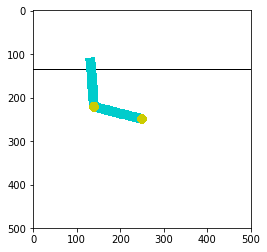

In [15]:
fig = plt.figure()
idx = 5
print(snapshot[idx][0], snapshot[idx][1])
display_frames_as_gif(snapshot[idx][2])

In [9]:
[i[1] for i in snapshot]

[132,
 130,
 108,
 111,
 148,
 118,
 121,
 129,
 121,
 149,
 148,
 125,
 120,
 133,
 123,
 137]